#Recurrent Neural Nets

##What you'll learn
1.  What is a recurrent neural network
2.  What kinds of problems are recurrent networks best suited for
3.  What are the architectural choices for a recurrent neural net

##Order of topics
1.  Introduction to recurrent networks
2.  Ramalho's Theano code for Elman network
3.  Discussion of Theano scan function
4.  Stock price prediction with recurrent net
5.  Karpathy's 100-line python character-based language model

##Reading material
https://www.willamette.edu/~gorr/classes/cs449/rnn1.html - class notes from Gorr's RNN lecture

http://arxiv.org/pdf/1506.00019v4.pdf - Lipton's excellent review of RNN

http://www.nehalemlabs.net/prototype/blog/2013/10/10/implementing-a-recurrent-neural-network-in-python/ - Discussion of RNN and theano code for Elman network - Tiago Ramalho

http://deeplearning.net/software/theano/library/scan.html#module-theano.scan_module - Read this documentation on theano scan function and run through some of the example code for its use.  

##Intro to RNN
Network models and math from various of the readings. 

##Theano Scan function
You've seen from the intro that with RNN's, the value of the hidden layer output is a function of the input and of the past hidden layer outputs.  The theano scan function stores as many past values of the hidden 

http://deeplearning.net/software/theano/library/scan.html#lib-scan - check examples and scroll 2/3 down page to "reference" for details.

http://deeplearning.net/software/theano/tutorial/loop.html

Here are a couple of the examples from the documentation on the scan function.  


In [12]:
import theano
import theano.tensor as T

k = T.iscalar("k")
A = T.vector("A")

# Symbolic description of the result
result, updates = theano.scan(fn=lambda prior_result, A: prior_result * A,
                              outputs_info=T.ones_like(A),
                              non_sequences=A,
                              n_steps=k)

# We only care about A**k, but scan has provided us with A**1 through A**k.
# Discard the values that we don't care about. Scan is smart enough to
# notice this and not waste memory saving them.
final_result = result[-1]

# compiled function that returns A**k
power = theano.function(inputs=[A,k], outputs=final_result, updates=updates)

print power(range(10),2)
print power(range(10),4)

[  0.   1.   4.   9.  16.  25.  36.  49.  64.  81.]
[  0.00000000e+00   1.00000000e+00   1.60000000e+01   8.10000000e+01
   2.56000000e+02   6.25000000e+02   1.29600000e+03   2.40100000e+03
   4.09600000e+03   6.56100000e+03]


##Q's
1  Match lambda function inputs to the other arguments in the scan arg list.

In [10]:
import numpy

coefficients = theano.tensor.vector("coefficients")
x = T.scalar("x")

max_coefficients_supported = 10000

# Generate the components of the polynomial
components, updates = theano.scan(fn=lambda coefficient, power, free_variable: coefficient * (free_variable ** power),
                                  outputs_info=None,
                                  sequences=[coefficients, theano.tensor.arange(max_coefficients_supported)],
                                  non_sequences=x)
# Sum them up
polynomial = components.sum()

# Compile a function
calculate_polynomial = theano.function(inputs=[coefficients, x], outputs=polynomial)

# Test
test_coefficients = numpy.asarray([1, 0, 2], dtype=numpy.float32)
test_value = 3
print calculate_polynomial(test_coefficients, test_value)
print 1.0 * (3 ** 0) + 0.0 * (3 ** 1) + 2.0 * (3 ** 2)
g = T.grad(polynomial, x)
calc_grad = theano.function([coefficients, x], g)
calc_grad(test_coefficients, test_value)

19.0
19.0


array(12.0, dtype=float32)

##Q
1.  Write an expression for the derivative of the polynomial that scan is calculating in the code above.  Evaluate it at a few values of x and see if the answers compare.
2.  Rerun the experiment in question 1 (immediately above) for some different polynomials. 
3.  Explain how the gradient is being calculated through the scan operation.  What are the steps that scan is taking?

In [14]:
def oneStep(u_tm4, u_t, x_tm3, x_tm1, y_tm1, W, W_in_1, W_in_2,  W_feedback, W_out):

  x_t = T.tanh(theano.dot(x_tm1, W) + \
               theano.dot(u_t,   W_in_1) + \
               theano.dot(u_tm4, W_in_2) + \
               theano.dot(y_tm1, W_feedback))
  y_t = theano.dot(x_tm3, W_out)

  return [x_t, y_t]

In [ ]:
W = T.matrix()
W_in_1 = T.matrix()
W_in_2 = T.matrix()
W_feedback = T.matrix()
W_out = T.matrix()

u = T.matrix() # it is a sequence of vectors
x0 = T.matrix() # initial state of x has to be a matrix, since
                # it has to cover x[-3]
y0 = T.vector() # y0 is just a vector since scan has only to provide
                # y[-1]


([x_vals, y_vals], updates) = theano.scan(fn=oneStep,
                                          sequences=dict(input=u, taps=[-4,-0]),
                                          outputs_info=[dict(initial=x0, taps=[-3,-1]), y0],
                                          non_sequences=[W, W_in_1, W_in_2, W_feedback, W_out],
                                          strict=True)
     # for second input y, scan adds -1 in output_taps by default

##A Theano RNN
The code below implements a single layer Elman network in theano.  The code was written by Tiago Ramalho and comes from his github page - https://gist.github.com/tmramalho/5e8fda10f99233b2370f.  

iteration 0: 2.09426307678
iteration 10000: 0.0625283718109
iteration 20000: 0.719514608383
iteration 30000: 0.995535969734
iteration 40000: 0.681394934654
iteration 50000: 0.376378536224
iteration 60000: 0.0633955001831
iteration 70000: 0.23927283287
iteration 80000: 0.119526267052
iteration 90000: 0.564009547234
iteration 100000: 0.351581573486
iteration 110000: 0.217575073242
iteration 120000: 0.16767680645
iteration 130000: 0.0334808826447
iteration 140000: 0.0208132266998
iteration 150000: 0.230397224426
iteration 160000: 0.113218545914
iteration 170000: 0.0179162025452
iteration 180000: 0.196667671204
iteration 190000: 0.056088924408
iteration 200000: 0.141449928284
iteration 210000: 0.00644361972809
iteration 220000: 0.0299093723297
iteration 230000: 0.00022554397583
iteration 240000: 0.0248272418976
iteration 250000: 0.0303966999054
iteration 260000: 0.0143444538116
iteration 270000: 0.0223622322083
iteration 280000: 0.0114002227783
iteration 290000: 0.00817358493805
iteration 

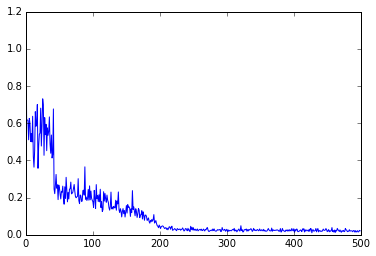

In [2]:
#from https://gist.github.com/tmramalho/5e8fda10f99233b2370f
import theano
import theano.tensor as T
import numpy as np
import cPickle
import random
import matplotlib.pyplot as plt
%matplotlib inline

class RNN(object):

    def __init__(self, nin, n_hidden, nout):
        rng = np.random.RandomState(1234)
        W_uh = np.asarray(rng.normal(size=(nin, n_hidden), scale= .01, loc = .0), dtype = theano.config.floatX)
        W_hh = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale=.01, loc = .0), dtype = theano.config.floatX)
        W_hy = np.asarray(rng.normal(size=(n_hidden, nout), scale =.01, loc=0.0), dtype = theano.config.floatX)
        b_hh = np.zeros((n_hidden,), dtype=theano.config.floatX)
        b_hy = np.zeros((nout,), dtype=theano.config.floatX)
        self.activ = T.nnet.sigmoid
        lr = T.scalar()
        u = T.matrix()
        t = T.scalar()

        W_uh = theano.shared(W_uh, 'W_uh')
        W_hh = theano.shared(W_hh, 'W_hh')
        W_hy = theano.shared(W_hy, 'W_hy')
        b_hh = theano.shared(b_hh, 'b_hh')
        b_hy = theano.shared(b_hy, 'b_hy')

        h0_tm1 = theano.shared(np.zeros(n_hidden, dtype=theano.config.floatX))

        h, _ = theano.scan(self.recurrent_fn, sequences = u,
                           outputs_info = [h0_tm1],
                           non_sequences = [W_hh, W_uh, W_hy, b_hh])

        y = T.dot(h[-1], W_hy) + b_hy
        cost = ((t - y)**2).mean(axis=0).sum()

        gW_hh, gW_uh, gW_hy,\
            gb_hh, gb_hy = T.grad(
            cost, [W_hh, W_uh, W_hy, b_hh, b_hy])

        self.train_step = theano.function([u, t, lr], cost,
            on_unused_input='warn',
            updates=[(W_hh, W_hh - lr*gW_hh),
            (W_uh, W_uh - lr*gW_uh),
            (W_hy, W_hy - lr*gW_hy),
            (b_hh, b_hh - lr*gb_hh),
            (b_hy, b_hy - lr*gb_hy)],
            allow_input_downcast=True)

    def recurrent_fn(self, u_t, h_tm1, W_hh, W_uh, W_hy, b_hh):
        h_t = self.activ(T.dot(h_tm1, W_hh) + T.dot(u_t, W_uh) + b_hh)
        return h_t

if __name__ == '__main__':
    rnn = RNN(2, 20, 1)
    lr = 0.01
    e = 1
    vals = []
    for i in xrange(int(5e5)):
        u = np.random.rand(10,2)
        t = np.dot(u[:,0], u[:,1])
        c = rnn.train_step(u, t, lr)
        if i%10000 == 0: print "iteration {0}: {1}".format(i, np.sqrt(c))
        e = 0.1*np.sqrt(c) + 0.9*e
        if i % 1000 == 0:
            vals.append(e)
    plt.plot(vals)
    plt.show()
    

##Q
1.  How frequently is the gradient being calculated in the code above?
2.  How frequently is a gradient step being taken?

##Stock Price Prediction
The code below adapts Ramalho's rnn code to the task of predicting stock prices.  The input data for the rnn is generated by a short python program (framer.py) that reads the raw data and generates attribute and label files.  There's a file folder containing daily data for all the stocks in the S&P 500.  The dataset includes about 3000 days of data - a little more than 10 years for each of the 500 stocks included in the index.  For each day, there are 5 numeric values - four prices (open high low close) and one volume.  The python program that generates the input has a couple of parameters - how many days of history to include in the attributes and how many days into the future to make the prediction.  The data being used in the rnn below uses one day of past data and generates a prediction of the change in closing price days into the future.  The program framer.py indicates that the label standard variation is about 3.5 for the symbol "a" that is the data source for the program below.  Compare that to the smoothed rms error in predicting the 5 day change.  What r-squared would you say the rnn is generating?  

iteration 0: 1.28242719173
iteration 10: 2.1814520359
iteration 20: 10.0960464478
iteration 30: 3.39931869507
iteration 40: 2.53961920738
iteration 50: 5.02067708969
iteration 60: 12.6134777069
iteration 70: 21.8684120178
iteration 80: 7.81989955902
iteration 90: 13.2518558502
iteration 100: 10.9278945923
iteration 110: 1.4697728157
iteration 120: 19.3817806244
iteration 130: 4.69277095795
iteration 140: 4.93961524963
iteration 150: 3.66370368004
iteration 160: 6.11796569824
iteration 170: 9.18711090088
iteration 180: 4.71939945221
iteration 190: 3.8073246479
iteration 200: 2.89441585541
iteration 210: 0.753311157227
iteration 220: 12.8787851334
iteration 230: 1.00186002254
iteration 240: 3.18443202972
iteration 250: 1.61186552048
iteration 260: 0.0607705116272
iteration 270: 6.45117044449
iteration 280: 1.45480668545
iteration 290: 1.54165410995
iteration 300: 0.215069770813
iteration 310: 4.22497177124
iteration 320: 6.48544168472
iteration 330: 1.43369174004
iteration 340: 0.3864347

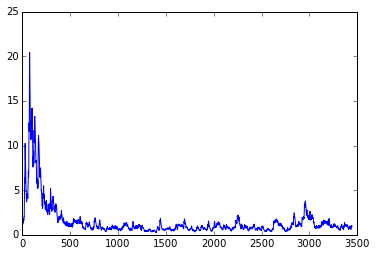

In [3]:
__author__ = 'mike.bowles'
#based on  code from https://gist.github.com/tmramalho/5e8fda10f99233b2370f
import theano
import theano.tensor as T
import numpy as np
import cPickle as pickle
import random
import matplotlib.pyplot as plt
%matplotlib inline

class RNN(object):

    def __init__(self, nin, n_hidden, nout):
        rng = np.random.RandomState(1234)
        W_uh = np.asarray(rng.normal(size=(nin, n_hidden), scale= .01, loc = 0.0), dtype = theano.config.floatX)
        W_hh = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale=.01, loc = 0.0), dtype = theano.config.floatX)
        W_hy = np.asarray(rng.normal(size=(n_hidden, nout), scale =.01, loc=0.0), dtype = theano.config.floatX)
        b_hh = np.zeros((n_hidden,), dtype=theano.config.floatX)
        b_hy = np.zeros((nout,), dtype=theano.config.floatX)
        self.activ = T.nnet.sigmoid
        lr = T.scalar()
        u = T.matrix()
        t = T.scalar()

        W_uh = theano.shared(W_uh, 'W_uh')
        W_hh = theano.shared(W_hh, 'W_hh')
        W_hy = theano.shared(W_hy, 'W_hy')
        b_hh = theano.shared(b_hh, 'b_hh')
        b_hy = theano.shared(b_hy, 'b_hy')

        h0_tm1 = theano.shared(np.zeros(n_hidden, dtype=theano.config.floatX))
        #theano.printing.debugprint([h0_tm1, u, W_hh, W_uh, W_hy, b_hh, b_hy], print_type=True)
        h, _ = theano.scan(self.recurrent_fn, sequences = u,
                           outputs_info = [h0_tm1],
                           non_sequences = [W_hh, W_uh, W_hy, b_hh])

        y = T.dot(h[-1], W_hy) + b_hy
        cost = ((t - y)**2).mean(axis=0).sum()

        gW_hh, gW_uh, gW_hy,\
            gb_hh, gb_hy = T.grad(
            cost, [W_hh, W_uh, W_hy, b_hh, b_hy])
        #theano.printing.debugprint([h0_tm1], print_type=True)
        self.train_step = theano.function([u, t, lr], cost,
            on_unused_input='warn',
            updates=[(W_hh, W_hh - lr*gW_hh),
            (W_uh, W_uh - lr*gW_uh),
            (W_hy, W_hy - lr*gW_hy),
            (b_hh, b_hh - lr*gb_hh),
            (b_hy, b_hy - lr*gb_hy)],
            allow_input_downcast=True)

    def recurrent_fn(self, u_t, h_tm1, W_hh, W_uh, W_hy, b_hh):
        h_t = self.activ(T.dot(h_tm1, W_hh) + T.dot(u_t, W_uh) + b_hh)
        return h_t

if __name__ == '__main__':

    (xlist, ylist) = pickle.load(open('stockTT.bin', 'rb'))
    nInputs = len(xlist[0])
    x = np.array(xlist, dtype = theano.config.floatX)
    y = np.array(ylist, dtype = theano.config.floatX)
    nHidden = 20
    nOutputs = 1
    rnn = RNN(nInputs, nHidden, nOutputs)
    lr = 0.01
    e = 1.0
    nPasses = 1
    vals = []
    for i in range(nPasses):
        for j in range(len(x)):
            u = np.asarray(xlist[j], dtype = theano.config.floatX).reshape((1,nInputs))
            t = y[j]

            c = rnn.train_step(u, t, lr)
            if j%10==0: print "iteration {0}: {1}".format(j, np.sqrt(c))
            e = 0.1*np.sqrt(c) + 0.9*e
            vals.append(e)
    plt.plot(vals)
    plt.show()

##Q
1.  The network above takes in one day's worth of data and predicts the change in price five days into the future.  How is it making a prediction based on only one day?
2.  What things might you change to improve the performance of the network?

##Homework
Try changing the following things in the stock price prediction network and see what effect your changes have on the performance of the network.  
1.  More than one day's of history for input to the network.
2.  Wider hidden layer.
3.  Truncate the BPTT gradient calculation.
4.  Add another hidden layer to the rnn.
5.  Alter the activation function.  (e.g. try elu). 
6.  Try a different gradient algo
7.  Try absolute value of error instead of squared error.


In [1]:
"""
Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)
BSD License
"""
import numpy as np

# data I/O
data = open('input.txt', 'r').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print 'data has %d characters, %d unique.' % (data_size, vocab_size)
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

def lossFun(inputs, targets, hprev):
  """
  inputs,targets are both list of integers.
  hprev is Hx1 array of initial hidden state
  returns the loss, gradients on model parameters, and last hidden state
  """
  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = np.copy(hprev)
  loss = 0
  # forward pass
  for t in xrange(len(inputs)):
    xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    xs[t][inputs[t]] = 1
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
    ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
    loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
  # backward pass: compute gradients going backwards
  dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
  dbh, dby = np.zeros_like(bh), np.zeros_like(by)
  dhnext = np.zeros_like(hs[0])
  for t in reversed(xrange(len(inputs))):
    dy = np.copy(ps[t])
    dy[targets[t]] -= 1 # backprop into y
    dWhy += np.dot(dy, hs[t].T)
    dby += dy
    dh = np.dot(Why.T, dy) + dhnext # backprop into h
    dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
    dbh += dhraw
    dWxh += np.dot(dhraw, xs[t].T)
    dWhh += np.dot(dhraw, hs[t-1].T)
    dhnext = np.dot(Whh.T, dhraw)
  for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
    np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
  return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

def sample(h, seed_ix, n):
  """
  sample a sequence of integers from the model
  h is memory state, seed_ix is seed letter for first time step
  """
  x = np.zeros((vocab_size, 1))
  #probability of current char is 1.  all others 0
  x[seed_ix] = 1
  ixes = []
  for t in xrange(n):
    #from current letter, predict probs of next letter
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
    y = np.dot(Why, h) + by
    p = np.exp(y) / np.sum(np.exp(y))
    #take a random draw with predicted prob wts
    ix = np.random.choice(range(vocab_size), p=p.ravel())
    x = np.zeros((vocab_size, 1))
    x[ix] = 1
    ixes.append(ix)
  return ixes

n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
while True:
  # prepare inputs (we're sweeping from left to right in steps seq_length long)
  if p+seq_length+1 >= len(data) or n == 0:
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    p = 0 # go from start of data
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

  # sample from the model now and then
  if n % 100 == 0:
    sample_ix = sample(hprev, inputs[0], 200)
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    print '----\n %s \n----' % (txt, )

  # forward seq_length characters through the net and fetch gradient
  loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001
  if n % 100 == 0: print 'iter %d, loss: %f' % (n, smooth_loss) # print progress

  # perform parameter update with Adagrad
  for param, dparam, mem in zip([Wxh, Whh, Why, bh, by],
                                [dWxh, dWhh, dWhy, dbh, dby],
                                [mWxh, mWhh, mWhy, mbh, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

  p += seq_length # move data pointer
  n += 1 # iteration counter

data has 30088 characters, 58 unique.
----
 :cMM.pcBEPrK:B Njg
lYi.cYenOapM
?OBN;CqG EnEdUs?dlV:BhS.vMLHPTIzIKOyK-l;Y!YWxPzAeqSWCIvC w-B';'iFBugTGHE;ghoDrkTITBpDKmHV:nWoSS zIKDHVts:Rqqqzp.ILFvWG!FGWpOsIKB:hl:Tx!C?hs;NkWB,..KdNNFrB:TtIV!qyrMe?dj 
----
iter 0, loss: 101.511079
----
 yvss woefais
o nseseiitoile d nl tlivv lhldi,,etFteed itrldenlr wyv ,e  liiirml wem fvvde,tyonsgkeesynenyftonl lsmwutitof
 l i ii goedeton 
 sridlnetobstolo soef si lo wivsn;eeyice gessdwdyy
byoslct,s 
----
iter 100, loss: 101.464662
----
 thetl?u  h thotythat th hh thet, tht tht . th oo whshthtd, ,ati shouotheT 
h thoote tod
Dh cenwho nh ththlth t
n thsitol thyht?t itoshootettoit :hd th otothf  wa thy th the thntishhltyrthes to;le thag 
----
iter 200, loss: 99.263991
----
 yucayuvou tyuyruy aauer loues yuue prv
cyvudu thoye
y ryeesu youyeosaon bu y ret ueudyuOeurragyryarurr uro lee chysc oeu yonoumy wyuyouyNyeunuryyueo  th sout vurna ue
geeruy seou sey eNlyrunfrT
no sou 
----
iter 300, loss: 96.521589
----
 

KeyboardInterrupt: 